In [3]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

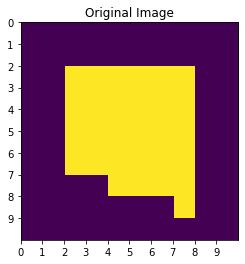

In [14]:
# A 8x8 binary image represented as a numpy array
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# Function for plotting the image using matplotlib
import matplotlib.pyplot as plt
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

In [15]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
   
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

print("image norm h \n",image_norm_h)
print("\n image norm v \n",image_norm_v)

image norm h 
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.16903085 0.16903085
 0.16903085 0.16903085 0.16903085 0.16903085 0.         0.
 0.         0.         0.16903085 0.16903085 0.16903085 0.16903085
 0.16903085 0.16903085 0.         0.         0.         0.
 0.16903085 0.16903085 0.16903085 0.16903085 0.16903085 0.16903085
 0.         0.         0.         0.         0.16903085 0.16903085
 0.16903085 0.16903085 0.16903085 0.16903085 0.         0.
 0.         0.         0.16903085 0.16903085 0.16903085 0.16903085
 0.16903085 0.16903085 0.         0.         0.         0.
 0.         0.         0.16903085 0.16903085 0.16903085 0.16903085
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.16903085 0.         0.
 0.         0.         0.         0.         0.     

In [16]:
 #Initialize some global variable for number of qubits
data_qb = 9
anc_qb = 1
total_qb = data_qb + anc_qb
print(" Total Qubit: ",total_qb)

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print("\n Amplitude permutation unitary \n",D2n_1)

 Total Qubit:  10

 Amplitude permutation unitary 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [17]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

Traceback (most recent call last):
  File "/tmp/ipykernel_179/3242316287.py", line 3, in <module>
    qc_h.initialize(image_norm_h, range(1, total_qb))
  File "/opt/conda/lib/python3.8/site-packages/qiskit/extensions/quantum_initializer/initializer.py", line 459, in initialize
    return self.append(Initialize(params, num_qubits), qubits)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/extensions/quantum_initializer/initializer.py", line 88, in __init__
    raise QiskitError("Desired statevector length not a positive power of 2.")
QiskitError: 'Desired statevector length not a positive power of 2.'

Use %tb to get the full traceback.


In [14]:
# Simulating the cirucits
from qiskit import Aer, QuantumCircuit, execute
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)
 
from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(sv_v[:30], max_size=30))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

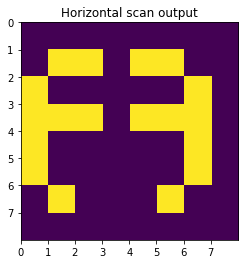

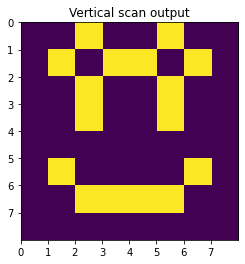

In [15]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

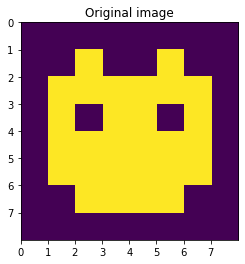

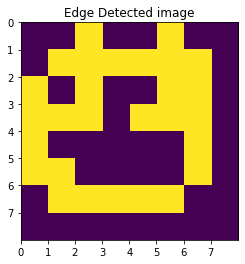

In [17]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')